In [1]:
using RxInfer, Random, StatsPlots, BenchmarkTools, LinearAlgebra, Profile, PProf

In [2]:
Threads.nthreads()

8

In [3]:
Threads.nthreads(:interactive)

8

In [47]:
module Parallel
	include("../parallel.jl")
end

Main.Parallel

In [5]:
n = 1000  # Number of coin flips
p = 0.75 # Bias of a coin

distribution = Bernoulli(p)
dataset      = float.(rand(Bernoulli(p), n))
prior = Beta(2.0, 6.0)

Beta{Float64}(α=2.0, β=6.0)

In [56]:
@model function coin_model(n, prior, prod_strategy, pipeline, meta)

    y = datavar(Float64, n)
	θ = randomvar() where { prod_strategy = prod_strategy, prod_constraint = nothing }

    θ ~ prior

    for i in 1:n
        y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
    end

end

In [7]:
prod(Parallel.MyCustomProd(10), prior, prior)

Beta{Float64}(α=3.0, β=11.0)

In [8]:
@btime RxInfer.create_model(coin_model(length($dataset), $prior, nothing,  Parallel.IThreadsPipelineStage(), nothing))

  4.155 ms (85118 allocations: 2.98 MiB)


(FactorGraphModel(), nothing)

In [9]:
@btime infer(
	model = coin_model(length($dataset), $prior, nothing, nothing, nothing),
	data  = (y = $dataset, ),
)

  8.098 ms (117272 allocations: 11.72 MiB)


Inference results:
  Posteriors       | available for (θ)


In [10]:
struct MyCustomRule
	size::Int
end

In [11]:
@rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
    @logscale -log(2)
    r = mean(q_out)
	s = det(inv(rand(meta.size, meta.size))) / 10^8
    return Beta(one(r) + r, 2one(r) - r)
end

In [27]:
@benchmark infer(
    model = coin_model(length($dataset), $prior, nothing, nothing, MyCustomRule(100)),
    data  = (y = $dataset, ),
)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.361 s …   2.406 s  ┊ GC (min … max): 0.61% … 0.49%
 Time  (median):     2.370 s              ┊ GC (median):    0.49%
 Time  (mean ± σ):   2.379 s ± 23.627 ms  ┊ GC (mean ± σ):  0.53% ± 0.07%

  █           █                                           █  
  █▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.36 s         Histogram: frequency by time        2.41 s <

 Memory estimate: 291.67 MiB, allocs estimate: 137272.

In [40]:
@benchmark infer(
    model = coin_model(length($dataset), $prior, Parallel.CustomProdStrategy(Parallel.fifo_prod), Parallel.IThreadsPipelineStage(), MyCustomRule(100)),
    data  = (y = $dataset, ),
)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  780.519 ms … 836.154 ms  ┊ GC (min … max): 0.00% … 2.74%
 Time  (median):     806.883 ms               ┊ GC (median):    2.76%
 Time  (mean ± σ):   809.003 ms ±  22.852 ms  ┊ GC (mean ± σ):  2.39% ± 1.07%

  ▁ ▁                   ▁     ▁              ▁                █  
  █▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  781 ms           Histogram: frequency by time          836 ms <

 Memory estimate: 292.45 MiB, allocs estimate: 147342.

In [50]:
@benchmark infer(
    model = coin_model(length($dataset), $prior, Parallel.CustomProdStrategy(Parallel.frfo_prod), Parallel.IThreadsPipelineStage(), MyCustomRule(100)),
    data  = (y = $dataset, ),
)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  774.101 ms … 842.701 ms  ┊ GC (min … max): 0.00% … 5.57%
 Time  (median):     801.017 ms               ┊ GC (median):    2.72%
 Time  (mean ± σ):   805.763 ms ±  22.245 ms  ┊ GC (mean ± σ):  3.14% ± 1.79%

  █                █ █   █        █          █                █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  774 ms           Histogram: frequency by time          843 ms <

 Memory estimate: 292.53 MiB, allocs estimate: 149358.

In [80]:
function run_test(prod_strategy, pipeline, size)
	rule = MyCustomRule(size)

	b = @benchmark infer(
	    model = coin_model(length($dataset), $prior, $prod_strategy, $pipeline, $rule),
	    data  = (y = $dataset, ),
	) seconds = 20

	println("Samples: $(length(b.times))")

	return minimum(b.times)
end

run_test (generic function with 1 method)

In [71]:
sizes = [1, 10, 60, 100]
rule_time = Vector{Float64}(undef, length(sizes))
time_s = Array{Float64}(undef, length(sizes))
time_mtp = Array{Float64}(undef, length(sizes))
time_fifo = Array{Float64}(undef, length(sizes))
time_mtp_fifo = Array{Float64}(undef, length(sizes))
time_mtp_frfo = Array{Float64}(undef, length(sizes));

In [81]:
for i in eachindex(sizes)
    println("Evaluating coin toss model with matrix size: $(sizes[i]) and samples: $n")
    bc = @benchmark RxInfer.create_model(coin_model(length($dataset), $prior, nothing, nothing,  MyCustomRule(sizes[$i])))
    b = @benchmark @call_rule Bernoulli(:p, Marginalisation) (q_out = PointMass(1), meta = MyCustomRule(sizes[$i]))
    rule_time[i] = median(b.times)

    time_s[i] = run_test(nothing, nothing, sizes[i]) - median(bc.times)
    time_mtp[i] = run_test(nothing, Parallel.IThreadsPipelineStage(), sizes[i]) - median(bc.times)
    time_fifo[i] = run_test(Parallel.CustomProdStrategy(Parallel.fifo_prod), nothing, sizes[i]) - median(bc.times)
    time_mtp_fifo[i] = run_test(Parallel.CustomProdStrategy(Parallel.fifo_prod), Parallel.IThreadsPipelineStage(), sizes[i]) - median(bc.times)
    time_mtp_frfo[i] = run_test(Parallel.CustomProdStrategy(Parallel.frfo_prod), Parallel.IThreadsPipelineStage(), sizes[i]) - median(bc.times)
end

Evaluating coin toss model with matrix size: 1 and samples: 1000


Samples: 3377


Samples: 3046

Samples: 3416

Samples: 3009


Samples: 3008
Evaluating coin toss model with matrix size: 10 and samples: 1000


Samples: 2070


Samples: 2626


Samples: 2699


Samples: 2432


Samples: 2414
Evaluating coin toss model with matrix size: 60 and samples: 1000


Samples: 186


Samples: 128


Samples: 126


Samples: 124


Samples: 125
Evaluating coin toss model with matrix size: 100 and samples: 1000


Samples: 9


Samples: 23

Samples: 23


Samples: 23


Samples: 23


In [82]:
rel_speed_mtp = time_s ./ time_mtp
rel_speed_fifo = time_s ./ time_fifo
rel_speed_mtp_fifo = time_s ./ time_mtp_fifo
rel_speed_mtp_frfo = time_s ./ time_mtp_frfo
rule_time_ms = rule_time / 1000;

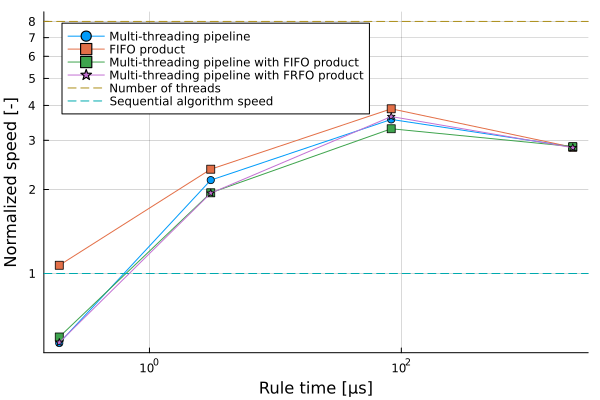

In [84]:
plot(
    xaxis=:log,
    yaxis=:log,
    legend=:topleft,
    xlabel="Rule time [μs]",
    ylabel="Normalized speed [-]",
    yticks=([1:Threads.nthreads(:interactive);], [string(a) for a in 1:Threads.nthreads(:interactive)]),
    gridalpha=0.3,
)
plot!(rule_time_ms, rel_speed_mtp, markershape=:circle, label="Multi-threading pipeline")
plot!(rule_time_ms, rel_speed_fifo, markershape=:rect, label="FIFO product")
plot!(rule_time_ms, rel_speed_mtp_fifo, markershape=:rect, label="Multi-threading pipeline with FIFO product")
plot!(rule_time_ms, rel_speed_mtp_frfo, markershape=:star5, label="Multi-threading pipeline with FRFO product")
hline!([Threads.nthreads(:interactive)], linestyle=:dash, label="Number of threads")
hline!([1], linestyle=:dash, label="Sequential algorithm speed")